In [ ]:
!pip install scikit-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Convert Image into Tensor

In [ ]:
transform = transforms.ToTensor()

# Load the MNIST datase 

In [ ]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform = transform)

In [ ]:
train_data

In [ ]:
test_data = datasets.MNIST(root='../Data', train= False , download=True, transform = transform)

In [ ]:
print(type(test_data))
print('----------------------------------')
print(test_data)

In [ ]:
# Display first sample in train data

print(train_data[0][0])

image, labels = train_data[0]
print(f"label: {labels}")

In [11]:
image.shape

torch.Size([1, 28, 28])

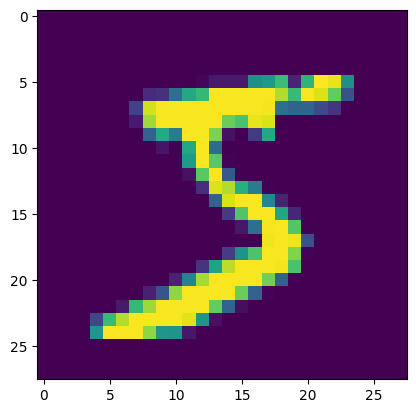

In [12]:
# Display the image

plt.imshow(image.reshape((28, 28)))

In [13]:
torch.manual_seed(101)


train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False) # -> take only 500 sample


# 

In [14]:
from torchvision.utils import make_grid
np.set_printoptions(formatter= dict(int = lambda x: f'{x:4}')) # for Formatting -> not necessary


# get first batch
for images, labels in train_loader:
    break

In [15]:
# the result for first batch -> (num_images_sample, channel, sizeOfImage(w, h))
images.shape

torch.Size([100, 1, 28, 28])

In [16]:
print(f'Number of labels/Sample {labels.shape}')
print('--------------------------------------------------------------------------------')
print(f'The labels: {labels}')

Number of labels/Sample torch.Size([100])
--------------------------------------------------------------------------------
The labels: tensor([7, 2, 3, 5, 8, 5, 3, 6, 9, 9, 1, 3, 5, 5, 4, 5, 4, 1, 0, 4, 5, 4, 5, 4,
        0, 5, 8, 2, 2, 3, 3, 7, 2, 8, 1, 2, 3, 1, 7, 9, 0, 4, 9, 1, 7, 9, 7, 2,
        6, 5, 5, 8, 5, 0, 4, 0, 0, 4, 9, 2, 6, 0, 8, 4, 1, 8, 5, 2, 0, 3, 3, 4,
        6, 1, 5, 3, 5, 9, 0, 7, 4, 5, 3, 6, 6, 4, 5, 3, 9, 7, 1, 7, 6, 7, 9, 3,
        5, 9, 9, 6])


In [17]:
#Print first 12 labels
print(f'First 12 Labels: {labels[:12].numpy()}') # Will print it as list

First 12 Labels: [   7    2    3    5    8    5    3    6    9    9    1    3]


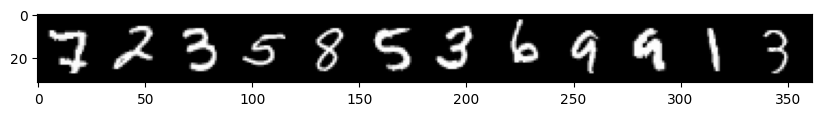

In [18]:
# Displayl Plot the first 12 images
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10, 4))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0))) #(1, 2, 0) -> change from (ch, w, h) to (w, h, ch)

# Create Network  ------------------------- 

In [19]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X)) 
        X = self.fc3(X) 
        
        return F.log_softmax(X, dim=1)

In [20]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
model

MultiLayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# From ANN to CNN 

In [21]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [22]:
 print('Total Parameters = ', 94080 +120 +10080 +84 + 840 +10)

Total Parameters =  105214


# Set the Loss Function and the Optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

"""
 -> These parameters include weights and biases of all the layers in the model
When you call `model.parameters()`, you're essentially
asking PyTorch to provide you with access to all the model's
parameters so that you can update them during training.
"""

"\n -> These parameters include weights and biases of all the layers in the model\nWhen you call `model.parameters()`, you're essentially\nasking PyTorch to provide you with access to all the model's\nparameters so that you can update them during training.\n"

In [24]:
images.shape # convert it from [100, 1, 28, 28] to [100, 784]

torch.Size([100, 1, 28, 28])

In [25]:
images.view(100, -1).shape

torch.Size([100, 784])

# Build the Training Loop

In [26]:
import time
start_time = time.time()  # Record the start time for tracking the duration of training.

# Training ----
epochs = 10  
# Tracking ----
train_losses = []  # store training losses for each epoch.
test_losses = []   # store test losses for each epoch.
train_correct = []  # store the number of correct predictions on training data for each epoch.
test_correct = []   #  the number of correct predictions on test data for each epoch.

for i in range(epochs): 
    trn_corr = 0  
    tst_corr = 0 
    
    # Training the model ---------------------------------------------------------
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1  # Increment batch number (just for display purposes).

        y_pred = model(X_train.view(100, -1))  # Forward pass: get predictions from the model.
        loss = criterion(y_pred, y_train)  # Calculate the loss between predictions and actual labels.
 
        # Get the predicted class index (the index of the maximum value in the output).
        predicted = torch.max(y_pred.data, 1)[1]

        # Count the number of correct predictions in this batch and add it to the total for this epoch.
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optim.zero_grad()  # Zero out gradients to prevent accumulation.
        loss.backward()   # Backpropagation: compute gradients of the model's parameters.
        optim.step()      # Optimization step: update model parameters based on gradients.

        if b % 200 == 0:
            # Calculate and display the accuracy for the current training batch.
            accuracy = (trn_corr.item() * 100) / (100 * b)
            print(f"Epoch: {i}  batch: {b}  loss: {loss.item()}  accuracy: {accuracy}")

    train_losses.append(loss.detach().numpy())  # Store the final loss for this epoch in the train_losses list.
    train_correct.append(trn_corr.item())  # Store the total number of correct predictions for this epoch.

    # Evaluate the model -------------------------------------------------------------------
    with torch.no_grad():  # Temporarily disable gradient calculations during evaluation.
        for b, (X_test, y_test) in enumerate(test_loader):
            b += 1
            y_val = model(X_test.view(500, -1))  # Forward pass: get predictions from the model.
            predicted = torch.max(y_val.data, 1)[1]  # Get the predicted class index.

            # Count the number of correct predictions in this batch and add it to the total for this epoch.
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)  # Calculate the loss on the last batch of test data.
    test_losses.append(loss.detach().numpy())  # Store the final loss for this epoch in the test_losses list.
    test_correct.append(tst_corr.item())  # Store the total number of correct predictions on test data.

# Display the Duration. Time that takes to train the model
total_time = time.time() - start_time  
print(f"Duration: {total_time/60} mins")


Epoch: 0  batch: 200  loss: 0.2356237769126892  accuracy: 83.245
Epoch: 0  batch: 400  loss: 0.3533070683479309  accuracy: 87.5325
Epoch: 0  batch: 600  loss: 0.13765770196914673  accuracy: 89.58166666666666
Epoch: 1  batch: 200  loss: 0.24507994949817657  accuracy: 94.88
Epoch: 1  batch: 400  loss: 0.1415732353925705  accuracy: 95.105
Epoch: 1  batch: 600  loss: 0.07288370281457901  accuracy: 95.36833333333334
Epoch: 2  batch: 200  loss: 0.08517584949731827  accuracy: 96.61
Epoch: 2  batch: 400  loss: 0.0613258071243763  accuracy: 96.6975
Epoch: 2  batch: 600  loss: 0.06279159337282181  accuracy: 96.75
Epoch: 3  batch: 200  loss: 0.11695744842290878  accuracy: 97.63
Epoch: 3  batch: 400  loss: 0.05154387652873993  accuracy: 97.4875
Epoch: 3  batch: 600  loss: 0.03660447522997856  accuracy: 97.51333333333334
Epoch: 4  batch: 200  loss: 0.10782866179943085  accuracy: 98.125
Epoch: 4  batch: 400  loss: 0.046118758618831635  accuracy: 98.0275
Epoch: 4  batch: 600  loss: 0.0537848845124244

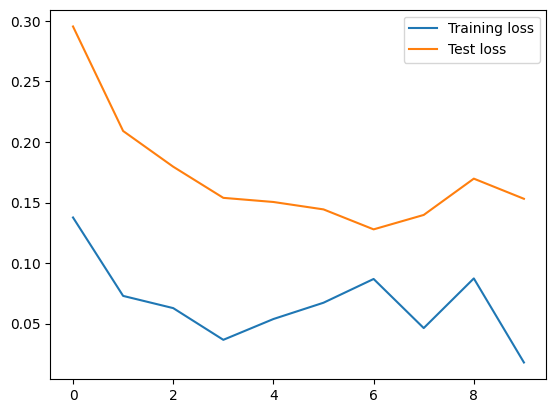

In [29]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [38]:
# Percentage of correct 
train_correct[0] /600 

train_acc = [t/600 for t in train_correct]
print (f"Percentage of correct in Training \n {train_acc}")

Percentage of correct in Training 
 [89.58166666666666, 95.36833333333334, 96.75, 97.51333333333334, 98.01666666666667, 98.39666666666666, 98.67833333333333, 98.92833333333333, 99.105, 99.3]


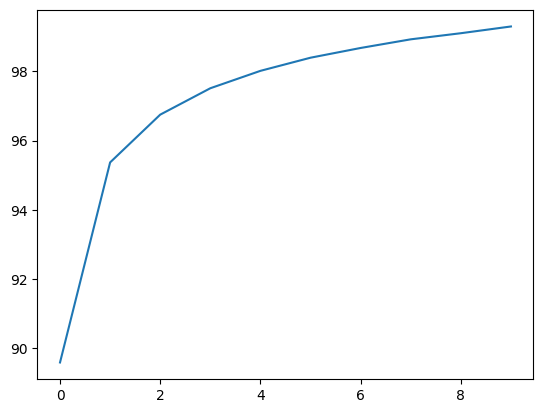

In [51]:
plt.plot(train_acc, label='Training Accuracy')

# New Unseen Data

In [40]:
test_loader_all = DataLoader(test_data, batch_size=10000, shuffle=False) 

In [45]:
 with torch.no_grad():
        correct =0 
        
        for (X_test, y_test) in test_loader_all:
            y_val = model(X_test.view(len(X_test), -1))
            predicted = torch.max(y_val.data, 1)[1]

            correct += (predicted == y_test).sum()

In [49]:
100 * correct.item()/ len(test_data)

97.73

# Confusion Matrix 

In [ ]:
pip install seaborn

In [61]:
cm = confusion_matrix(predicted.view(-1), y_test.view(-1))

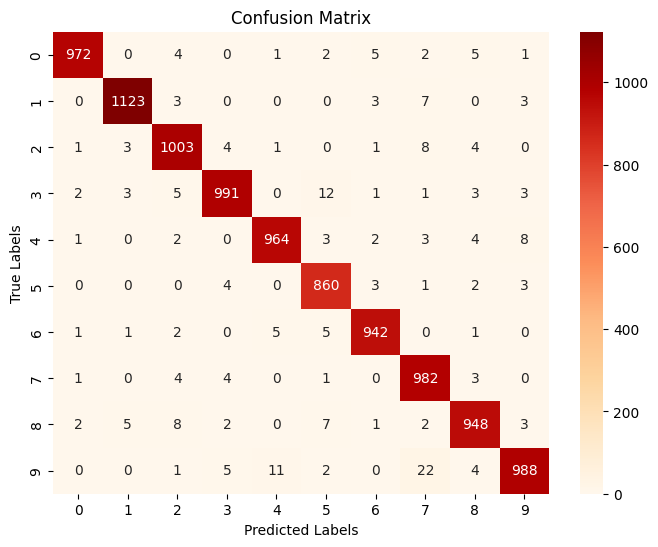

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define the colormap (for example, using 'coolwarm' colormap)
cmap = 'OrRd'

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()